<div style="font-family: Calibri; background-color: #ccd5ae; padding: 10px 10px;">
    <h1>BalancedRandomForest</h1>
</div>

In [32]:
import pandas as pd
import numpy as np
import warnings
from sklearn import set_config
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scripts.plot_tetha import plot_model
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score

In [33]:
%load_ext autoreload
%autoreload 2
from scripts.scores import calc_predict_proba, calc_scores, confusion_matrix_display
from scripts.decision_tree import determine_parameter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
warnings.filterwarnings("ignore") 
set_config(display='diagram')
pd.options.display.precision=3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<div style="font-family: Calibri; background-color: #faedcd; padding: 5px;">
    <h2>1. Loading Train and Test dataset</h2>
    <p>Train-Test split is not required, as both dataset provided are separate.</p>
</div>

In [4]:
df = pd.read_csv("data/train.csv" )
df.shape

(255347, 18)

In [5]:
X_train = df.drop(columns=['Default', 'LoanID', 'DTIRatio', 'CreditScore'])
y_train = df['Default']
print(X_train.shape)
print(y_train.shape)

(255347, 14)
(255347,)


In [6]:
df_test = pd.read_csv("data/test.csv")
df_predictions = pd.read_csv("data/prediction_submission.csv")
df_test = pd.merge(left=df_test,right=df_predictions, left_on='LoanID',right_on='LoanID')
df_test.shape

(109435, 18)

In [7]:
y_test =  df_test['predicted_probability']
X_test = df_test.drop(columns=['LoanID', 'DTIRatio', 'CreditScore', 'predicted_probability'])
print(X_test.shape)
print(y_test.shape)

(109435, 14)
(109435,)


In [8]:
(df_test['predicted_probability']!= df_predictions['predicted_probability']).sum()

0

<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>2. Column Transformation</h2>
</div>

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Univariate Analysis - Conclusion (Recap)</h3>    
    <ul>
            <li>HasCoSigner, HasDependents, HasMortgage are binary fields</li>
            <li>Education, EmploymentType, LoanPurpose, MaritalStatus are categorical data</li>
    </ul>        
    <h4>Transformation is done external to pipeline to avoid the redundent step In GridSearchCV
    </h4>
</div>

In [10]:
transformer = ColumnTransformer(
    [
        ('Binary', OneHotEncoder(drop='if_binary'), ['HasCoSigner', 'HasDependents', 'HasMortgage']),
        ('multi_category', OneHotEncoder(),  ['Education', 'EmploymentType', 'MaritalStatus']),
        ('Loan_category', OneHotEncoder(categories = [['Business', 'Home']], handle_unknown='ignore'), ['LoanPurpose']),    
    ], remainder='passthrough'
)

In [11]:
X_train = transformer.fit_transform(X_train)

In [12]:
X_test = transformer.transform(X_test)

<div style="font-family: Calibri; background-color: #faedcd; padding: 5px;">
    <h2>3. Determine The Decision Tree Parameters</h2>
</div>

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>1. max_depth</h4>    
    <ul>
            <li>Purpose: Limits the depth (number of levels) of the tree.</li>
            <li>Tip: A very deep tree can overfit; setting a maximum depth helps control model complexity.</li>
    </ul>        
</div>

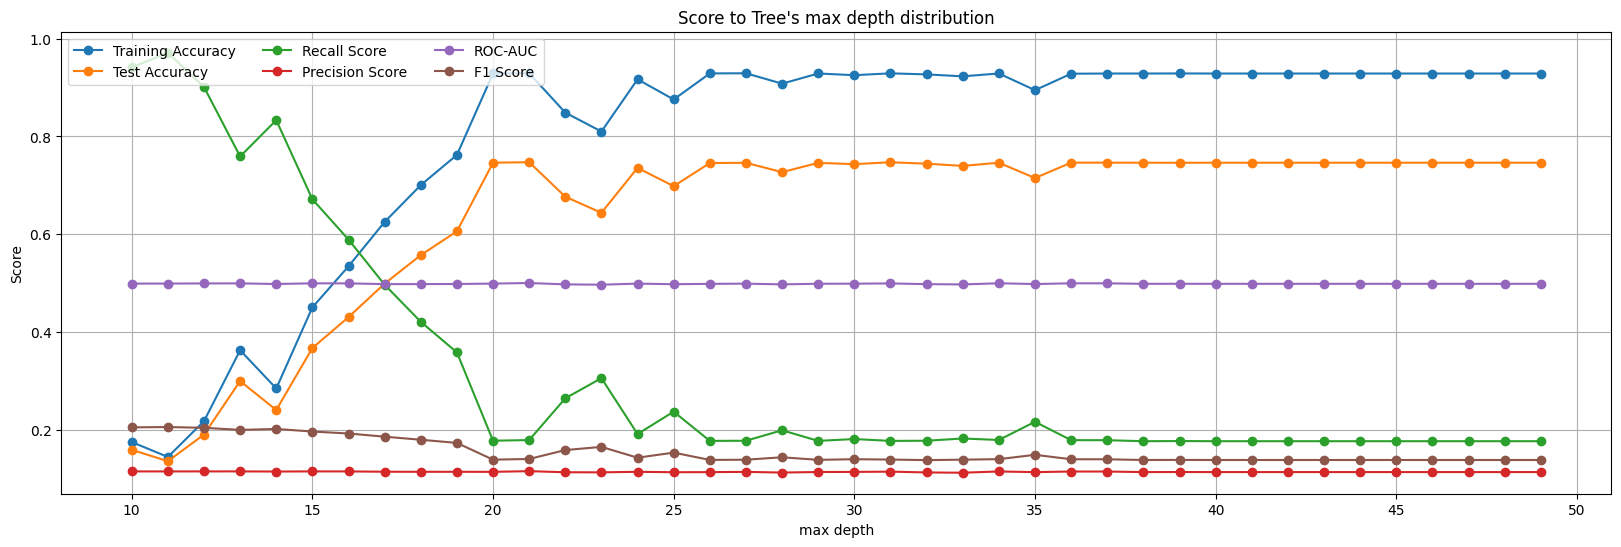

In [14]:
determine_parameter(X_train, y_train, X_test, y_test, BalancedRandomForestClassifier, "max_depth", range(10,50))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>2. min_samples_split</h4>    
    <ul>
        <li>Purpose: The minimum number of samples required to split an internal node.</li>
        <li>Tip: Increasing this value can make the tree more general and reduce overfitting.</li>
    </ul>        
</div>

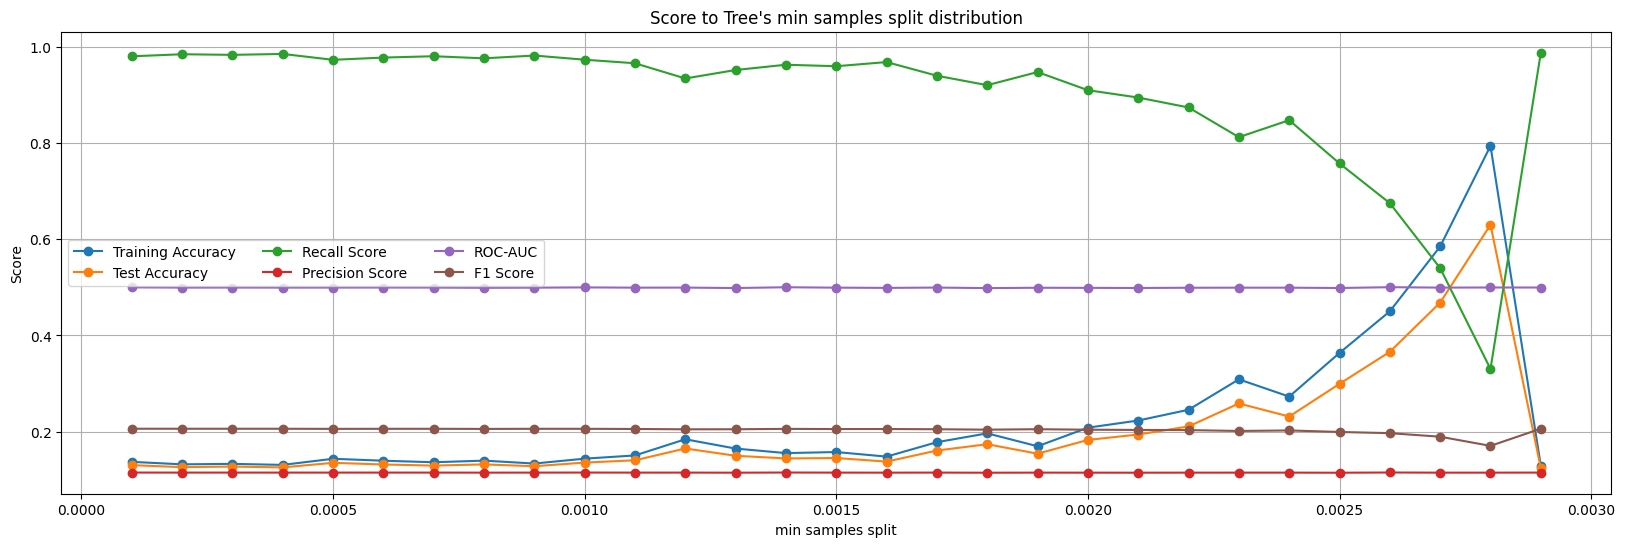

In [15]:
determine_parameter(X_train, y_train, X_test, y_test, BalancedRandomForestClassifier,"min_samples_split", np.arange(0.0001,0.003,0.0001))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>3. min_samples_leaf</h4>    
    <ul>
        <li>Purpose: The minimum number of samples required to be at a leaf node.</li>
        <li>Tip: Larger values can reduce variance (smoothing the model), which might help avoid overfitting.</li>
    </ul>        
</div>

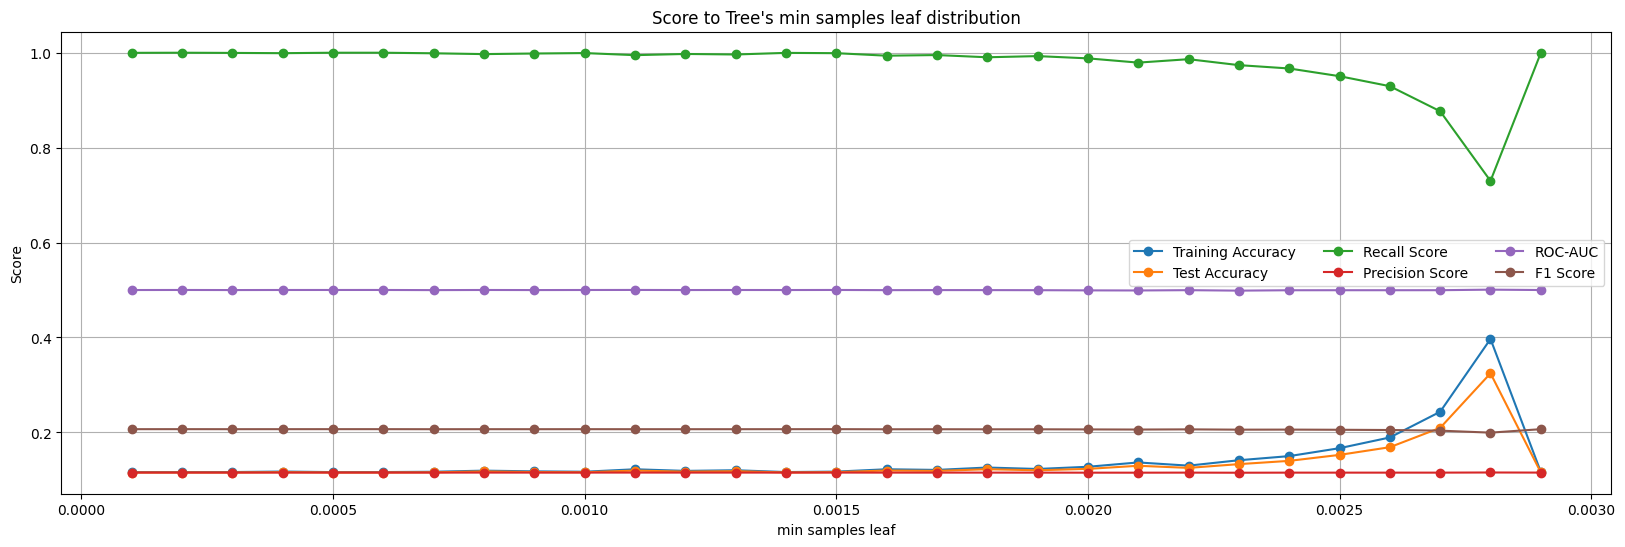

In [16]:
determine_parameter(X_train, y_train, X_test, y_test, BalancedRandomForestClassifier,"min_samples_leaf", np.arange(0.0001,0.003,0.0001))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>4. max_features</h4>    
    <ul>
        <li>Purpose: The number of features to consider when looking for the best split.</li>
    </ul>        
</div>

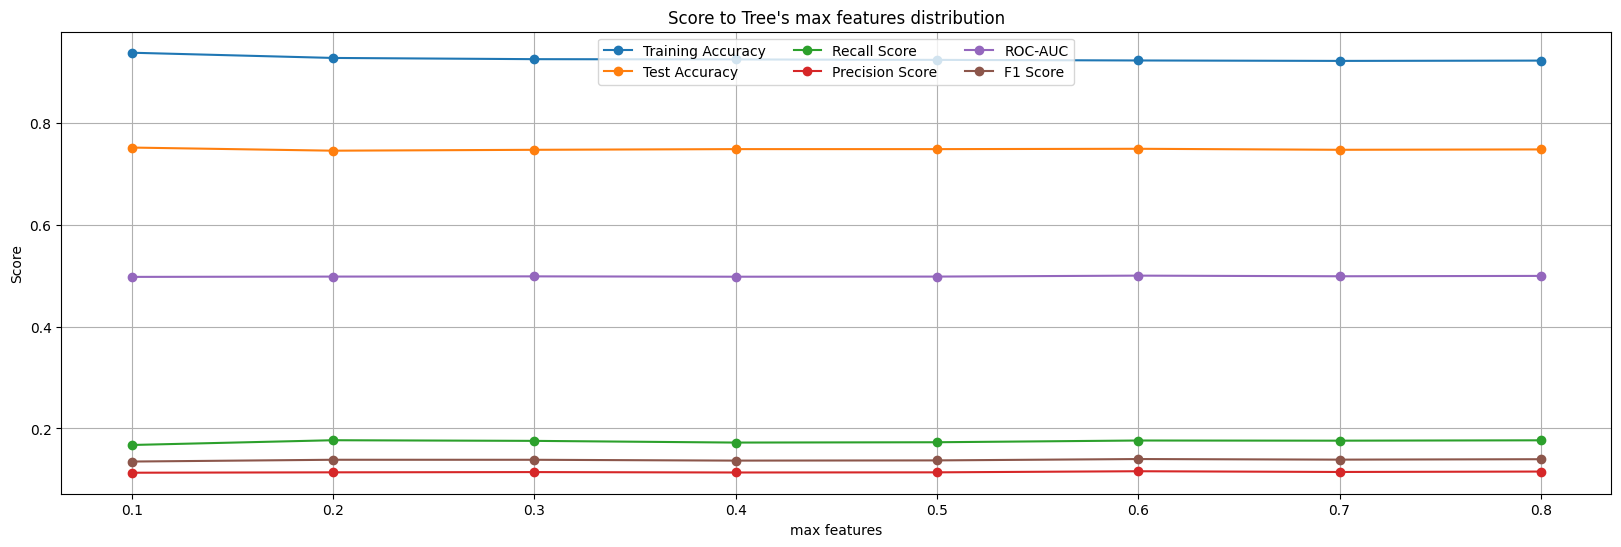

In [17]:
determine_parameter(X_train, y_train, X_test, y_test, BalancedRandomForestClassifier,"max_features", np.arange(0.1,0.9,0.1))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>5. min_impurity_decrease</h4>    
    <ul>
        <li>A node will be split if this split induces a decrease of the impurity greater than or equal to this value.</li>
    </ul>        
</div>

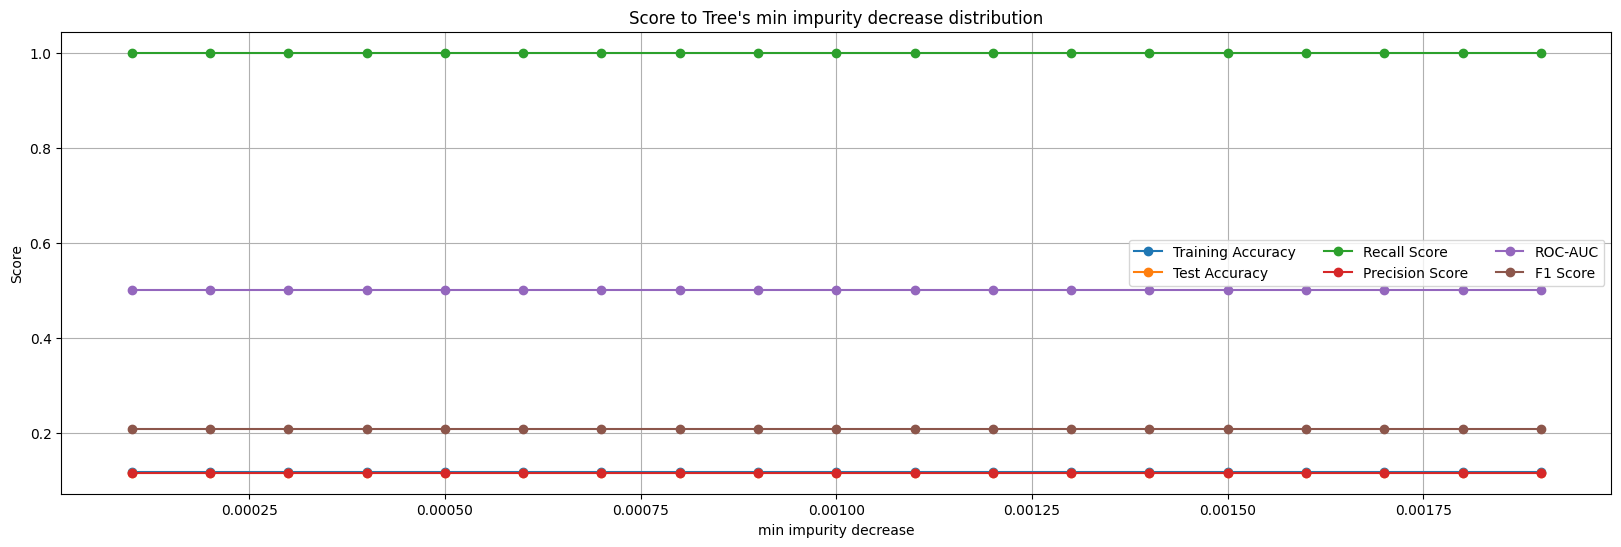

In [18]:
determine_parameter(X_train, y_train, X_test, y_test, BalancedRandomForestClassifier,"min_impurity_decrease", np.arange(0.0001,0.002,0.0001))

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Decision Tree's Parameter Analysis Conclusion</h3>  
    <ul>
        <li>min_samples_split &#x2705;</li>        
        <ul>
            <li>Recall score best range static is between 0.10 to 0.20</li>            
        </ul>
    </ul>        
    <ul>
        <li>min_samples_leaf &#x2705;</li>        
        <ul>
            <li>Recall score best range is stabilized at 0.15. Score went above 60%</li>            
        </ul>
    </ul>            
    <ul>
        <li>min_impurity_decrease &#x274C;</li>  
        <li>max_features &#x274C;</li>
        <li>max_leaf_nodes &#x274C;</li>
        <ul><li>The graph for these 3 features pretty much is flat line, indicating this parementer does not contribute enough to improve prediction</li></ul>
    </ul>        
    <ul>
        <li>max_depth  &#x2705;</li>        
        <ul>
            <li>The recall score is readually decreasing as depth increases</li>
            <li>Training and Test score were in upword trend, indicating accuracy getting better. But simultanelously Recall, and precision score are decreasing</li>
            </li>Peak is at aroung 11</li>
        </ul>
    </ul>        
</div>

<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px;">
    <h2>4. DecisionTree</h2>
    <font size=4>        
    <ul>
        <li>GridSearchCV</li>
        <li>Decision Tree using class weight</li>
    </ul>
    </font>
</div>

In [19]:
classifier = BalancedRandomForestClassifier(
     n_estimators= 15,
     class_weight='balanced',
     random_state=42,
     sampling_strategy='auto',
     replacement=True,
     n_jobs=-1
)

In [20]:
param_grid = [
    {
        'min_samples_split': [0.0026, 0.0027],
        'max_depth': [16,17]
    },
    {    
        'max_depth': [16,17]
    },
    {
        'min_samples_split': [0.0026, 0.0027],
    }
]

In [36]:
scoring = {'accuracy': make_scorer(fbeta_score, beta=2, pos_label=1), 'prec': 'precision'}
cv = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose=True, scoring='balanced_accuracy');

In [37]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      n_estimators=15,
                                                      n_jobs=-1,
                                                      random_state=42,
                                                      sampling_strategy='auto'),
             n_jobs=-1,
             param_grid=[{'max_depth': [16, 17],
                          'min_samples_split': [0.0026, 0.0027]},
                         {'max_depth': [16, 17]},
                         {'min_samples_split': [0.0026, 0.0027]}],
             scoring='balanced_accuracy', verbose=True)

In [38]:
print("Best Parameters:", cv.best_params_)
print("Best CV Score:", cv.best_score_)

Best Parameters: {'max_depth': 17}
Best CV Score: 0.6290256567722285


In [39]:
model = cv.best_estimator_
model

BalancedRandomForestClassifier(class_weight='balanced', max_depth=17,
                               n_estimators=15, n_jobs=-1, random_state=42,
                               sampling_strategy='auto')

In [40]:
y_pred = model.predict(X_test)

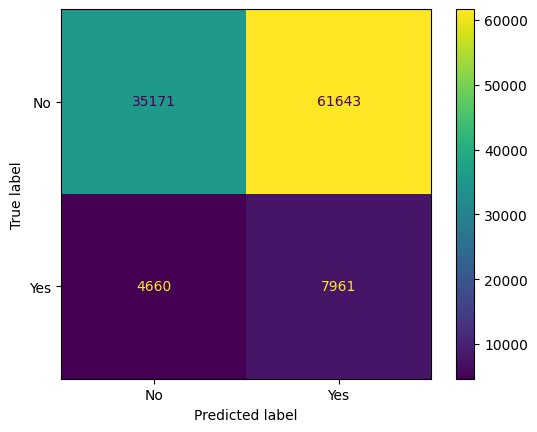

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', display_labels=["No","Yes"]);

In [42]:
rs = recall_score(y_test, y_pred, pos_label=1)
ps = precision_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
ac = accuracy_score(y_test, y_pred)

In [43]:
print(f"{'Recall Score:':<20}{rs:<5}")
print(f"{'Precision Score:':<20}{ps:<5}")
print(f"{'F1 Score:':<20}{f1:<5}")
print(f"{'Accuracy Score:':<20}{ac:<5}")

Recall Score:       0.6307741066476508
Precision Score:    0.11437561059709211
F1 Score:           0.19363940407418667
Accuracy Score:     0.3941335039064285


In [29]:
y_train_pred_prob, y_test_pred_prob = calc_predict_proba(model, X_train, y_train, X_test, y_test)

In [34]:
rs_list, ps_list, f1_list, ac_list = [],[],[],[]
for thresh in np.arange(0.3,0.8,0.1):
    rs, ps, f1, ac, y_test_pred = calc_scores(model, X_train, y_train, y_train_pred_prob, X_test, y_test, y_test_pred_prob, thresh)
    rs_list.append(rs) 
    ps_list.append(ps)
    f1_list.append(f1)
    ac_list.append(ac)

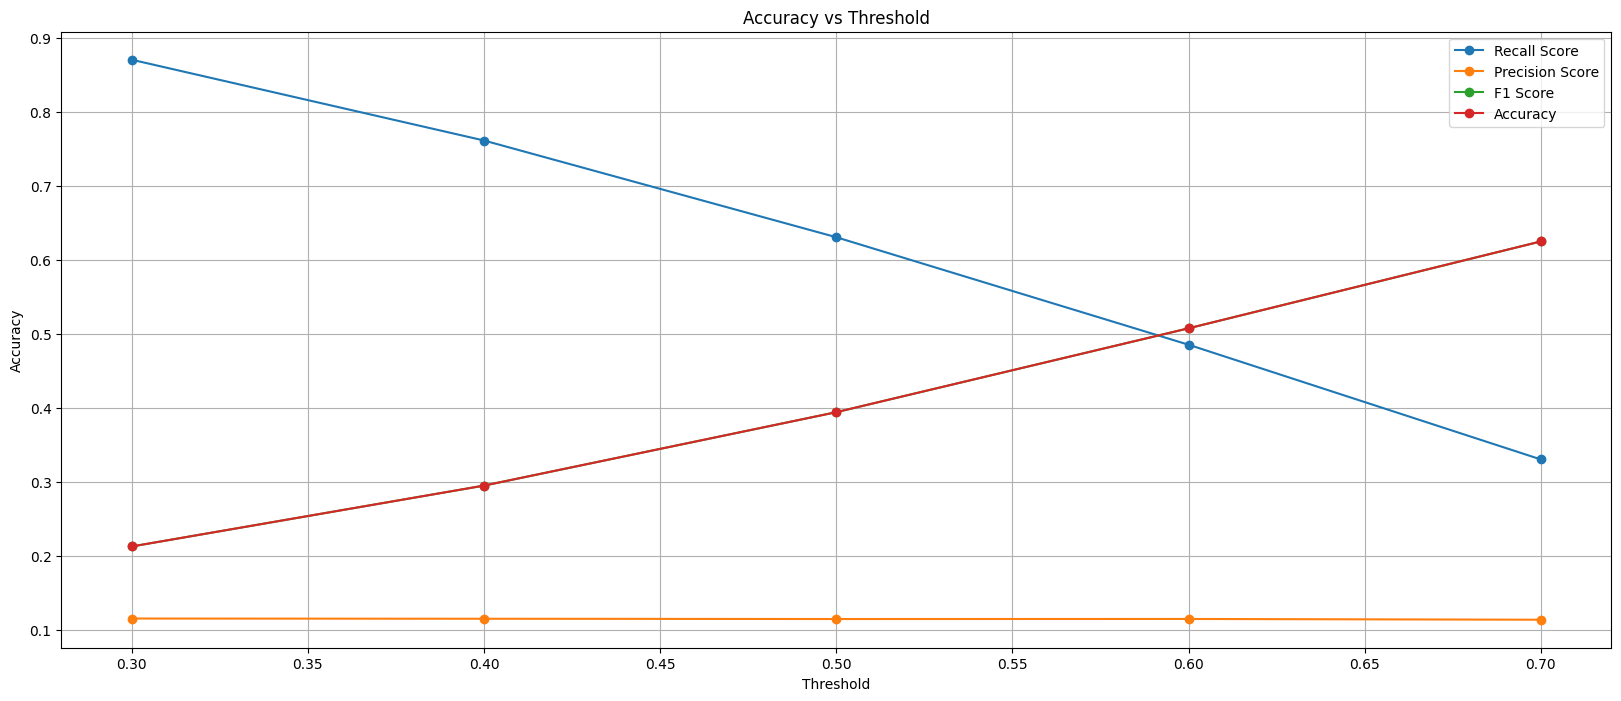

In [35]:
plt.figure(figsize=(20, 8))

plt.plot(np.arange(0.3,0.8,0.1), rs_list, label='Recall Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ps_list, label='Precision Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), f1_list, label='F1 Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ac_list, label='Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()